# Monitoring of model
 Evaluate model on data and obtain metrics of performance

## Load libraries

In [1]:
pip install tabgan==1.3.3

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install lightgbm

In [3]:
pip install scikit-plot

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install scipy==1.11.4

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install --upgrade pandas "dask[complete]"

Note: you may need to restart the kernel to use updated packages.


In [6]:
## librerias requeridas
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import re
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from scikitplot.metrics import plot_roc
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_lift_curve
from scikitplot.helpers import binary_ks_curve 
from scikitplot.metrics import plot_ks_statistic
from scikitplot.helpers import cumulative_gain_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from datetime import datetime, timedelta

import pyarrow as pa
import pyarrow.parquet as pq

In [7]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.memory_usage', True)

## Load model and data to evaluate

Load variables names from file

In [8]:
import os
os.getcwd()

'/home/ec2-user/SageMaker/viamericas-dev/Analytics/5.Fraud'

In [9]:
import os
import joblib
# load model
#modelo = joblib.load("ModeloV2TodosMenosVariables.pkl") 
#variables = open('./ModeloV2TodosMenosVariables.txt','r')
modelo = joblib.load("ModeloFinal2.pkl") 
variables = open('./ModeloFinal2.txt','r')

In [10]:
modelo

LGBMClassifier(colsample_bytree=0.84, importance_type='gini',
               learning_rate=0.07, max_depth=20, min_child_weight=0.0026,
               n_estimators=520, num_leaves=30, objective='binary',
               scale_pos_weight=0.003, subsample=1)

## Veo si puedo sacar los nombres directo del modelo q cargue
## Veo como cargar el punto de corte

In [11]:
variables = open('./ModeloFinal2.txt','r')
var_input = variables.read()

In [12]:
var_input = ['01_branch_working_days', 'branch_minutes_since_last_transaction',
    'branch_trans_3m', 'branch_has_fraud', 
    'branch_trans_40min', 'branch_trans_10min', 'cash_pick_up_40min', 
    'location_nro_fraud', 'sender_trans_3m', 
    'sender_nro_fraud','01_isMexico', 
    '01_sender_branch_state', '01_var_range_hist',
    '01_branch_fraud', '01_location_fraud', '01_sender_fraud', 
    '01_isCashPick', '01_isBankDep', 
    'sender_days_to_last_transaction_more7m', 
    '01_receiver_transaction_count', '01_sender_sending_days',
    '01_branch_working_days', '01_net_amount_receiver', 
    '01_sender_minutes_since_last_transaction_2days', 
    '01_sender_days_to_last_transaction_365', 
    '01_sender_days_to_last_transaction_7m', '01_hour_receiver']

In [13]:
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/TargetTodos"
dfTrain = pd.read_parquet(f"s3://{s3_url}/Train/Train.parquet")
tgTrain = dfTrain['target']

dfVal = pd.read_parquet(f"s3://{s3_url}/Validation/Validation.parquet")
tgVal = dfVal['target']

#Uni test y Val
#X = pd.concat([dfTrain[var_input], dfVal[var_input]], ignore_index=True) 
X = pd.concat([dfTrain, dfVal], ignore_index=True) 
Y = pd.DataFrame(pd.concat([dfTrain['target'], dfVal['target']], ignore_index=True)) 

dias_target = ['day_name_receiver_0', 'day_name_receiver_1',
       'day_name_receiver_2', 'day_name_receiver_3',
       'day_name_receiver_4', 'day_name_receiver_5',
       'day_name_receiver_6','target']

testeo =  pd.concat([X, Y], axis=1)
Y_target = pd.DataFrame(pd.concat([dfTrain[dias_target], dfVal[dias_target]], ignore_index=True)) 

In [14]:
# Uso esto para sacar el punto de corte. Cuando lo pueda guardar esta celda se va
# Prediciendo la variable objetivo para el conjunto de datos de prueba 'X_TESTEO' utilizando el clasificador LightGBM
testeo_data_pred_rf = modelo.predict(testeo[var_input])

# Prediciendo las probabilidades de clase para cada observación en 'X_TESTEO' utilizando el clasificador LightGBM
probab_rf = modelo.predict_proba(testeo[var_input])

# Eliminando la primera columna (se asume que son las probabilidades de la clase negativa) de las probabilidades predichas
# Se asume que la segunda columna contiene las probabilidades para la clase positiva
score_rf = np.delete(probab_rf, np.s_[0], axis=1)

# Creando una copia del DataFrame 'Y_c' para preservar los datos originales
Y_c = Y_target.copy()

# Agregando una nueva columna 'preds_rf' al DataFrame copiado con las predicciones del clasificador LightGBM
Y_c['preds_rf'] = testeo_data_pred_rf

# Agregando una nueva columna 'score_rf' al DataFrame copiado con las probabilidades de la clase positiva
Y_c['score_rf'] = score_rf

#Calculo el primer percentil para sacar el punto de corte
percentiles = pd.qcut(Y_c['score_rf'], q=1000, duplicates='drop')
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
Y_c['FRAUD_DECILE'] = np.nan
Y_c['FRAUD_DECILE'] = percentiles
Y_c['FRAUD_DECILE'] = Y_c['FRAUD_DECILE'].astype('Int32')

#saco el punto de corte del primer centil para aplicarlo al test
corte_01 = Y_c.score_rf[Y_c['FRAUD_DECILE']==1].min()
corte_02 = Y_c.score_rf[Y_c['FRAUD_DECILE']==2].min()
corte_03 = Y_c.score_rf[Y_c['FRAUD_DECILE']==3].min()
corte_04 = Y_c.score_rf[Y_c['FRAUD_DECILE']==4].min()
corte = Y_c.score_rf[Y_c['FRAUD_DECILE']==10].min()

In [15]:
corte

1.976573014763343e-08

In [16]:
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/TargetTodos"
tes = pd.read_parquet(f"s3://{s3_url}/Data2024/Data2024.parquet")

testeo = pd.concat([X, tes], axis = 0, ignore_index=True)
Y_target = pd.DataFrame(pd.concat([Y_target, tes[dias_target]], ignore_index=True)) 

## Apply model

In [17]:
def limpiar_nombres_columnas(dataframe):
    """
    Limpia y estandariza los nombres de las columnas en un DataFrame.

    Parameters:
    - dataframe: DataFrame de pandas.

    Returns:
    - DataFrame con nombres de columnas limpios.
    """
    dataframe = dataframe.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
    return dataframe

testeo = limpiar_nombres_columnas(testeo)

In [18]:
testeo['target'].value_counts(dropna=False)

target
False    23212824
True          419
Name: count, dtype: int64

In [19]:
Y_target.shape

(23213243, 8)

In [20]:
# Prediciendo la variable objetivo para el conjunto de datos de prueba 'X_TESTEO' utilizando el clasificador LightGBM
testeo_data_pred_rf = modelo.predict(testeo[var_input])

# Prediciendo las probabilidades de clase para cada observación en 'X_TESTEO' utilizando el clasificador LightGBM
probab_rf = modelo.predict_proba(testeo[var_input])

# Eliminando la primera columna (se asume que son las probabilidades de la clase negativa) de las probabilidades predichas
# Se asume que la segunda columna contiene las probabilidades para la clase positiva
score_rf = np.delete(probab_rf, np.s_[0], axis=1)


In [21]:
# Creando una copia del DataFrame 'Y_TESTEO' para preservar los datos originales
Y_c = Y_target.copy()

# Agregando una nueva columna 'preds_rf' al DataFrame copiado con las predicciones del clasificador LightGBM
Y_c['preds_rf'] = testeo_data_pred_rf

# Agregando una nueva columna 'score_rf' al DataFrame copiado con las probabilidades de la clase positiva
Y_c['score_rf'] = score_rf

In [22]:
pd.DataFrame(confusion_matrix(Y_c['target'], Y_c['preds_rf']))

,0,1
0,23212676,148
1,239,180


In [23]:
Y_c['pred_corte'] = Y_c['score_rf']>corte
pd.DataFrame(confusion_matrix(Y_c['target'], Y_c['pred_corte']))

,0,1
0,22917827,294997
1,12,407


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='score_rf', ylabel='Count'>

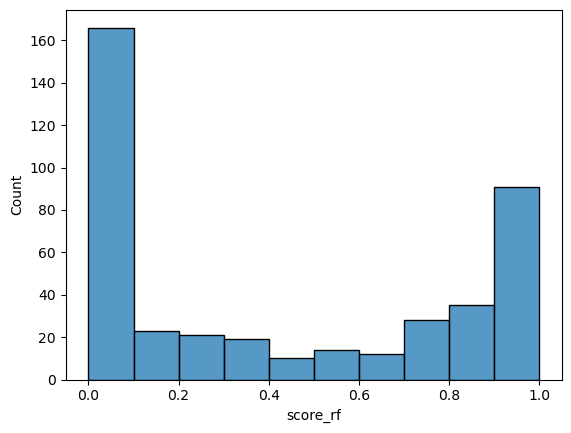

In [24]:
import seaborn as sns
sns.histplot(data = Y_c[Y_c['target'] == True], x='score_rf')

In [25]:
# Dividir las predicciones en deciles y calcular la captura del 30% en el conjunto de entrenamiento
percentiles = pd.qcut(Y_c['score_rf'], q=100, duplicates='drop')
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
Y_c['FRAUD_DECILE'] = np.nan
Y_c['FRAUD_DECILE'] = percentiles
Y_c['FRAUD_DECILE'] = Y_c['FRAUD_DECILE'].astype('Int32')
print('FRAUD CAPTURA 30%:')
print(sum(Y_c[Y_c['FRAUD_DECILE'] < 4]['target']) / sum(Y_c['target']))

FRAUD CAPTURA 30%:
0.9809069212410502


In [26]:
DECILES = pd.crosstab(Y_c['FRAUD_DECILE'], Y_c['target'])
DECILES

target,False,True
FRAUD_DECILE,,
1,231728,405
2,232129,3
3,232130,3
4,232131,1
5,232132,1
...,...,...
96,232133,0
97,232132,0
98,232133,0


In [27]:
Y_c[['score_rf','FRAUD_DECILE']].groupby(['FRAUD_DECILE']).agg({'score_rf': [ 'min', 'max']}) 

score_rf              
                       min           max
FRAUD_DECILE                            
1             3.186505e-08  1.000000e+00
2             8.200266e-09  3.186501e-08
3             3.764906e-09  8.200163e-09
4             2.180932e-09  3.764889e-09
5             1.428959e-09  2.180928e-09
...                    ...           ...
96            5.046690e-13  6.064305e-13
97            4.029493e-13  5.046690e-13
98            2.988555e-13  4.029484e-13
99            1.866068e-13  2.988549e-13
100           1.787409e-15  1.866054e-13

[100 rows x 2 columns]

In [28]:
#PERC = pd.crosstab(Y_c.FRAUD_DECILE[testeo['mes']>8], Y_c.target[testeo['mes']>8])
#PERC.to_csv ('./percentiles.csv')

## Analizo distintos puntos de corte

In [29]:
testeo['date_receiver'].dt.month
testeo['year'] = testeo['date_receiver'].dt.year
Y_c['fraud_classification'] = testeo['fraud_classification']
Y_c['targetF'] = (testeo['fraud_classification']=='Real')

In [30]:
#Veo cuantos falsos positivos tengo con el punto de corte
Y_c['pred_corte_01'] = Y_c['score_rf']>corte_01
tes_corte_01 = testeo[Y_c['pred_corte_01']==True]
Y_c_corte_01 = Y_c[Y_c['pred_corte_01']==True]

pd.crosstab(tes_corte_01['mes'], Y_c_corte_01['targetF'])

targetF,False,True
mes,,
1,8996,81
2,8726,41
3,9154,29
4,2120,61
5,2149,42
6,2027,65
7,2139,30
8,2263,36


In [31]:
#Veo cuantos falsos positivos tengo con el punto de corte
Y_c['pred_corte_02'] = Y_c['score_rf']>corte_02
tes_corte_02 = testeo[Y_c['pred_corte_02']==True]
Y_c_corte_02 = Y_c[Y_c['pred_corte_02']==True]

pd.crosstab(tes_corte_02['mes'], Y_c_corte_02['targetF'])

targetF,False,True
mes,,
1,16043,83
2,15786,45
3,16814,30
4,4256,61
5,4324,44
6,4184,68
7,4303,30
8,4467,37


In [32]:
#Veo cuantos falsos positivos tengo con el punto de corte
Y_c['pred_corte_03'] = Y_c['score_rf']>corte_03
tes_corte_03 = testeo[Y_c['pred_corte_03']==True]
Y_c_corte_03 = Y_c[Y_c['pred_corte_03']==True]

pd.crosstab(tes_corte_03['mes'], Y_c_corte_03['targetF'])

targetF,False,True
mes,,
1,22439,83
2,22088,45
3,23564,30
4,6346,61
5,6487,44
6,6252,68
7,6627,30
8,6667,37


In [33]:
#Veo cuantos falsos positivos tengo con el punto de corte
Y_c['pred_corte_04'] = Y_c['score_rf']>corte_04
tes_corte_04 = testeo[Y_c['pred_corte_04']==True]
Y_c_corte_04 = Y_c[Y_c['pred_corte_04']==True]

pd.crosstab(tes_corte_04['mes'], Y_c_corte_04['targetF'])

targetF,False,True
mes,,
1,28177,83
2,28051,46
3,30211,32
4,8398,61
5,8702,44
6,8313,69
7,8867,30
8,8792,37


## Curva ROC y FP

In [34]:
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_lift_curve
from scikitplot.helpers import binary_ks_curve
from scikitplot.metrics import plot_ks_statistic
from scikitplot.helpers import cumulative_gain_curve

In [35]:
# Calcular la curva de ganancia acumulativa y el LIFT del modelo en el conjunto de entrenamiento
classes = np.unique(Y_c[['target']])
percentages, gains = cumulative_gain_curve(Y_c[['target']], Y_c['score_rf'], classes[1])
percentages = percentages[1:]
gains = gains[1:]
gains = gains / percentages
indice = round(len(gains) * 0.1)
print('LIFT FRAUD TESTEO:')
print(gains[indice])

# Calcular el área bajo la curva ROC del modelo en el conjunto de entrenamiento
print('ROC FRAUD TESTEO:')
print(roc_auc_score(Y_c[['target']], Y_c['pred_corte']))

# Calcular la estadística KS del modelo en el conjunto de entrenamiento
thresholds, pct1, pct2, ks_statistic, max_distance_at, classes = binary_ks_curve(Y_c[['target']], Y_c['score_rf'])
print('KS FRAUD TESTEO:')
print(ks_statistic)

# Calcular la precisión y el recall del modelo en el conjunto de entrenamiento
precision = precision_score(Y_c[['target']], Y_c['pred_corte'])
recall = recall_score(Y_c[['target']], Y_c['pred_corte'])
print('Precision FRAUD TESTEO:')
print(precision)
print('Recall FRAUD TESTEO:')
print(recall)

LIFT FRAUD TESTEO:
9.880665278222125
ROC FRAUD TESTEO:
0.9793260092939474


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


KS FRAUD TESTEO:
0.9600389674571924
Precision FRAUD TESTEO:
0.0013777741669036303
Recall FRAUD TESTEO:
0.9713603818615751


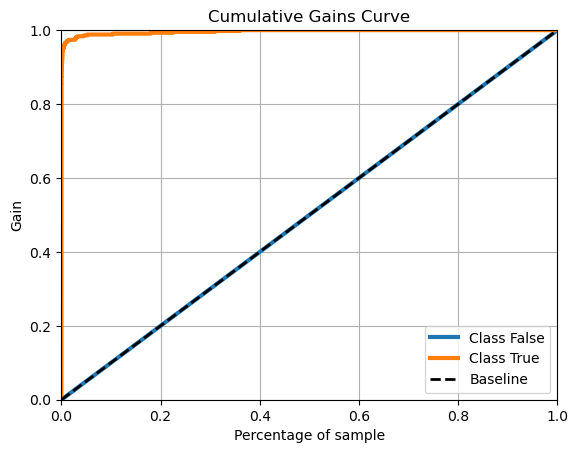

In [36]:
import scikitplot as skplt
skplt.metrics.plot_cumulative_gain(y_true=Y_c[['target']], y_probas =  probab_rf)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


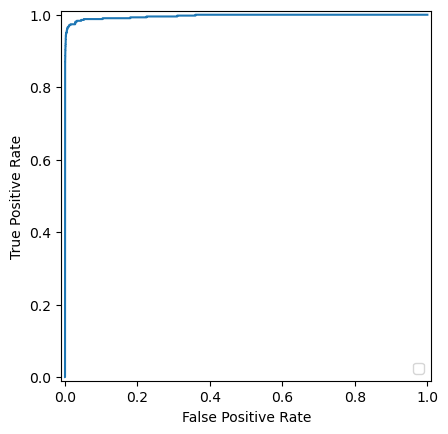

In [37]:
from sklearn.metrics import RocCurveDisplay, roc_curve

fpr, tpr, _ = roc_curve(Y_c[['target']], score_rf)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

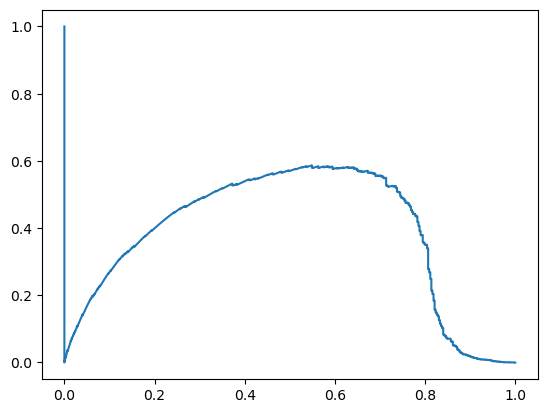

In [38]:
precision, recall, thresholds = skplt.metrics.precision_recall_curve(Y_c[['target']], score_rf)
plt.plot(recall, precision)

In [39]:
recall[recall>0.8].min() # 0.8010540184453228
precision[precision>0.8].min() #0.8002832861189801

1.0

## Monthly analysis

In [40]:
pd.crosstab(testeo['mes'], Y_c['target'])

target,False,True
mes,,
1,3732792,89
2,3887124,48
3,4381848,39
4,2116230,61
5,2289916,45
6,2193694,70
7,2314244,30
8,2296976,37


In [41]:
#Veo cuantos falsos positivos tengo con el punto de corte
tes_corte = testeo[Y_c['pred_corte']==True]
Y_c_corte = Y_c[Y_c['pred_corte']==True]

pd.crosstab(tes_corte['mes'], Y_c_corte['target'])

target,False,True
mes,,
1,59692,86
2,60580,46
3,66482,33
4,20724,61
5,22092,45
6,21555,69
7,22319,30
8,21553,37


In [42]:
Tabla_mes = pd.DataFrame(pd.concat([testeo['mes'],testeo['fraud_classification'], 
                                     Y_c['FRAUD_DECILE'], Y_c['target']],axis=1))

In [43]:
Tabla_mes[Tabla_mes['target']==True]
pd.crosstab(Tabla_mes.mes, Tabla_mes.FRAUD_DECILE)

FRAUD_DECILE,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
mes,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,48015,42271,40637,39288,38622,38200,37674,37718,37098,37435,36717,36987,37064,37113,37130,37077,36924,37419,36779,37129,37415,37087,37194,37700,37317,37039,37256,37357,37314,37768,37385,37630,37625,37888,37862,37570,37676,37672,37659,37729,37503,37639,38053,38047,38243,38137,38140,37738,37736,37953,37918,37977,37877,38031,37768,37770,37887,37886,37771,37560,37726,37867,37588,37411,37657,37468,37038,37095,37354,37204,37243,37315,37043,37241,36960,37012,36720,36381,36687,36512,36461,36445,36698,36581,36341,36128,35842,35953,35646,35569,35177,35206,35197,35206,35162,34854,34797,34855,35226,36941
2,48413,44095,42770,41477,40940,40408,40112,39721,39315,39359,39267,39388,39433,39008,39275,39386,39165,39072,39585,38990,39615,39115,39294,39595,39046,39616,39384,39582,39526,39410,39328,39130,39468,39224,39342,39431,39195,39102,39264,39604,39302,39286,39074,39453,39151,39483,39269,39176,38970,39300,38903,39137,39395,39261,39272,39352,39169,38972,38883,39160,38817,39145,38948,39125,38897,38900,38622,38923,38830,38829,38786,38527,38878,38643,38584,38436,38534,38497,38272,38236,38311,38005,37591,37715,37595,37685,37569,37066,36886,36980,36758,36370,36293,36331,35804,35781,35239,34962,34866,34518
3,52701,50098,48300,47415,46604,45401,45468,45150,45085,44263,44662,44089,44137,44290,44317,44387,44133,44381,43997,44116,44137,44419,44391,43967,44263,44225,44177,44107,44043,43848,43991,43873,43905,44148,44093,44102,43992,44132,44000,43959,44356,43962,44058,44132,43682,43722,43921,43921,43711,43560,43667,43639,43378,43898,43722,43779,43501,43619,43062,43397,43549,43224,43378,43546,43328,43547,43899,43558,43140,43228,43426,43168,43118,42866,43163,43097,43299,43040,42837,42816,42698,43212,43303,42782,43014,42621,42737,43036,42755,42712,42871,42681,42524,42255,42113,42094,41675,41337,40763,40024
4,16073,17430,17981,18398,18680,18655,18781,19065,19280,19244,19230,18936,19185,19388,18969,19263,19571,19045,19332,19344,18865,18856,18943,19238,18863,19289,18982,19106,19104,19275,19317,18929,19257,19186,19207,19188,19435,19363,19286,19331,19275,19512,19204,19381,19700,19662,19277,19864,19831,19786,19542,19869,19976,19903,19956,20215,20162,20551,20550,20488,20470,20708,20595,20817,20831,20763,21257,21097,21334,21352,21613,21560,22088,22112,22127,22156,22355,22857,22893,23033,23255,23549,23745,23730,24493,24388,24716,25220,25622,25805,26007,26552,27057,27393,28007,28335,29272,29749,30689,31115
5,16872,19840,20587,21137,21287,21992,21852,21962,21914,22267,22206,22271,22240,22034,21906,21761,22275,21819,21899,21913,21771,21971,21917,21717,21700,21889,21717,21854,21924,21915,21800,21855,22005,21725,21755,21813,21850,22166,21899,21708,21777,21740,21815,21666,21811,21850,22013,22097,22038,22119,22096,22054,22136,22260,22095,21991,22342,22019,22359,22413,22677,22581,22688,22508,22517,22651,22836,22996,23279,23158,23015,23066,23241,23587,23677,23621,23596,23688,24056,24235,24124,24336,24441,24853,24965,25083,25153,25002,25656,25774,25911,26047,26275,26685,26681,26587,27566,27867,27880,27726
6,16543,19403,20623,21795,22229,22391,22579,22526,23211,22983,23017,23247,22894,22935,22946,22938,22781,22674,22898,22822,22573,22835,22678,22490,22618,22405,22548,22142,22569,22352,22196,22479,22180,22157,22223,22155,22252,22318,22098,22185,22087,21794,22011,21666,21716,21532,21825,21686,21709,21719,21784,21782,21657,21319,21503,21682,21641,21573,21552,21582,21345,21326,21548,21365,21501,21555,21735,21530,21470,21523,21157,21503,21316,21333,21293,21516,21656,21496,21423,21504,21448,21467,21381,21527,21368,21586,21653,21721,21830,21725,21735,22032,22154,21830,22205,22725,225

In [44]:
pd.crosstab(Tabla_mes.mes[Tabla_mes['target']==True], Tabla_mes.FRAUD_DECILE[Tabla_mes['target']==True])

FRAUD_DECILE,1,2,3,4,5,6,11,19,23,31,37
mes,,,,,,,,,,,
1,85,2,0,0,0,0,0,0,1,0,1
2,46,0,1,0,0,0,0,1,0,0,0
3,32,1,2,1,1,0,1,0,0,1,0
4,61,0,0,0,0,0,0,0,0,0,0
5,45,0,0,0,0,0,0,0,0,0,0
6,69,0,0,0,0,1,0,0,0,0,0
7,30,0,0,0,0,0,0,0,0,0,0
8,37,0,0,0,0,0,0,0,0,0,0


In [45]:
Tabla_mes.loc[Tabla_mes['target']==True,['mes','fraud_classification','FRAUD_DECILE']]

,mes,fraud_classification,FRAUD_DECILE
18834,1,Real,1
29264,6,Real,1
124527,2,Real,1
357990,3,Real,1
392994,5,Real,1
...,...,...,...
22178813,3,Real,1
22489783,3,Real,31
23006071,3,Real,1
23028774,3,Real,1


# Monthly indicators

In [57]:
i = 0
summary_metrics = pd.DataFrame(columns = ['month','year', 'precision', 'recall','alerts','frauds&dist','frauds','detected'] )
for y in  testeo['year'].unique():
    for m in  testeo['mes'].unique():
        
        subset_mes = Y_c[(testeo['year']==y) & (testeo['mes']==m)]
        if not subset_mes.empty:
            precision = precision_score(subset_mes[['targetF']], subset_mes['pred_corte_01'])
            recall = recall_score(subset_mes[['targetF']], subset_mes['pred_corte_01'])
            summary_metrics.loc[i,'month'] = m
            summary_metrics.loc[i,'year'] = y
            summary_metrics.loc[i,'precision'] = precision
            summary_metrics.loc[i,'recall'] = recall
            summary_metrics.loc[i,'alerts'] = subset_mes['pred_corte_01'].sum()
            summary_metrics.loc[i,'frauds'] = subset_mes['target'].sum()
            summary_metrics.loc[i,'frauds&dist'] = subset_mes['target'].sum()
            summary_metrics.loc[i,'frauds'] = (subset_mes['fraud_classification']=='Real').sum()
            summary_metrics.loc[i,'detected'] = ((subset_mes['pred_corte_01']==True) & (subset_mes['target']==True) & (subset_mes['fraud_classification']=='Real')).sum()
            #print ('Year:', y, 'Month:',m)
            #print ('Precision:', precision, 'Recall:',recall)
            i = i+1
summary_metrics.sort_values(['year','month'])

,month,year,precision,recall,alerts,frauds&dist,frauds,detected
6,1,2023,0.037059,0.96875,1673,64,64,62
0,2,2023,0.018075,1.0,1881,34,34,34
5,3,2023,0.009383,0.954545,2238,22,22,21
1,4,2023,0.027969,1.0,2181,61,61,61
2,5,2023,0.019169,0.933333,2191,45,45,42
3,6,2023,0.031071,0.928571,2092,70,70,65
4,7,2023,0.013831,1.0,2169,30,30,30
7,8,2023,0.015659,0.972973,2299,37,37,36
10,1,2024,0.002566,0.76,7404,25,25,19
8,2,2024,0.001017,0.5,6886,14,14,7


In [47]:
summary_metrics.sort_values(['year','month'])

,month,year,precision,recall,alerts,frauds&dist,frauds,detected
6,1,2023,0.018705,0.984375,3368,64,64,63
0,2,2023,0.008861,1.0,3837,34,34,34
5,3,2023,0.004698,0.954545,4470,22,22,21
1,4,2023,0.01413,1.0,4317,61,61,61
2,5,2023,0.010073,0.977778,4368,45,45,44
3,6,2023,0.015992,0.971429,4252,70,70,68
4,7,2023,0.006924,1.0,4333,30,30,30
7,8,2023,0.008215,1.0,4504,37,37,37
10,1,2024,0.001568,0.8,12758,25,25,20
8,2,2024,0.000917,0.785714,11994,14,14,11


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


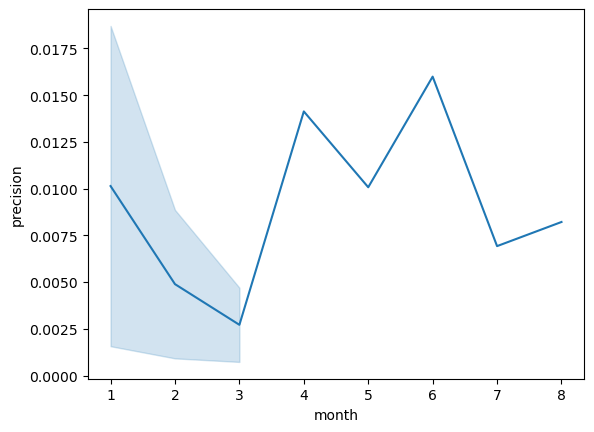

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


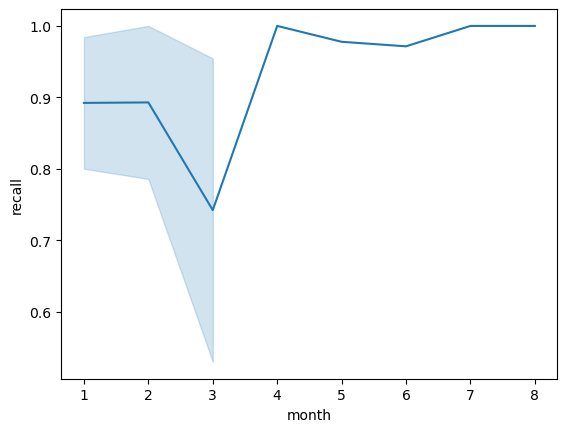

In [48]:
# Recall and precision by month
sns.lineplot(data = summary_metrics, x ='month', y = 'precision')
plt.show()
sns.lineplot(data = summary_metrics, x ='month', y= 'recall')
plt.show()

## Daily analysis

In [49]:
tes_corte_01['date_receiver'].dt.floor('d')

2881       2023-03-06
3808       2023-04-03
4050       2023-05-14
7958       2023-03-25
10313      2023-08-30
              ...    
23212656   2024-03-23
23212763   2024-03-22
23213087   2024-03-03
23213174   2024-03-14
23213223   2024-03-20
Name: date_receiver, Length: 37959, dtype: datetime64[ns]

In [50]:
ALERTAS_01 = pd.crosstab(tes_corte_01['date_receiver'].dt.floor('d'), Y_c_corte_01['targetF'])
#ALERTAS_01.to_csv ('./alertas.csv')

In [51]:
ALERTAS_01

targetF,False,True
date_receiver,,
2023-01-01,18,0
2023-01-02,48,0
2023-01-03,42,0
2023-01-04,71,11
2023-01-05,44,20
...,...,...
2024-03-26,146,0
2024-03-27,133,0
2024-03-28,119,0


In [52]:
FRAUDES = pd.crosstab(testeo['date_receiver'].dt.floor('d'), Y_c['targetF'])
#FRAUDES.to_csv ('./fraudes.csv')

In [53]:
FRAUDES

targetF,False,True
date_receiver,,
2023-01-01,15754,0
2023-01-02,58123,0
2023-01-03,48448,0
2023-01-04,44212,11
2023-01-05,43613,20
...,...,...
2024-03-27,52849,0
2024-03-28,48518,0
2024-03-29,65119,0


In [54]:
week_testigo = testeo['date_receiver'].between('2024-02-21','2024-02-28')
X_week_testigo = testeo[week_testigo]
Y_c_week_testigo = Y_c[week_testigo]

week_testigo.sum(), X_week_testigo.shape, Y_c_week_testigo.shape

(514265, (514265, 78), (514265, 18))

In [55]:
X_week_testigo_corte = X_week_testigo[Y_c_week_testigo['pred_corte_02']==True]
Y_c_week_testigo_corte = Y_c_week_testigo[Y_c_week_testigo['pred_corte_02']==True]

pd.crosstab(X_week_testigo_corte['date_receiver'].dt.day, Y_c_week_testigo_corte['target'])

target,False,True
date_receiver,,
21,315,0
22,388,0
23,477,0
24,499,3
25,463,0
26,454,0
27,333,4


In [56]:
#X_week_testigo_corte[['id_branch','id_receiver']].to_csv ('./alertas2024.csv')